In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path

from preprocessing import preprocess_ecmwf, preprocess_target, preprocess_raw_forecasts
from cnn_training import generate_climprob_inputs, ModelRegistry, construct_climdev_cnn, DEFAULT_FIT, DEFAULT_COMPILE, DEFAULT_CONSTRUCT
from verification import l1yocv_climatology, brier_skill_score, reliability_diagram

2022-09-08 09:12:36.527306: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-08 09:12:36.527339: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Description of forecast data
In "/data/volume_2/subseasonal/ecmwf/" we have stored extended range forecast data from the ecmwf center. This is a sub-set of the S2S database, a subset that was published as part of the S2S-AI competition https://s2s-ai-challenge.github.io/ 

The data is separated in 20 years of hindcasts (a.k.a. re-forecasts) with 11 members (2000-2019), and one year of operational forecasts with 51 members (2020).

Our target is 4-week accumulated rainfall in the Horn of Africa, forecast at a sub-seasonal lead time of 2 weeks. This means we evaluate the predictions over week 3+4+5+6. We have selected those weeks, and pre-aggregated all data for you, script: 'aggregation.py', data directory: "/data/volume_2/subseasonal/ecmwf/aggregated/". This gridded data is global, at a resolution of 1.5x1.5 degrees. Multiple variables are present:

In [2]:
list(Path('/data/volume_2/subseasonal/ecmwf/aggregated/forecast/').glob('*.nc'))

[PosixPath('/data/volume_2/subseasonal/ecmwf/aggregated/forecast/ecmwf-forecast-gh-week3456.nc'),
 PosixPath('/data/volume_2/subseasonal/ecmwf/aggregated/forecast/ecmwf-forecast-tcw-week3456.nc'),
 PosixPath('/data/volume_2/subseasonal/ecmwf/aggregated/forecast/ecmwf-forecast-t2m-week3456.nc'),
 PosixPath('/data/volume_2/subseasonal/ecmwf/aggregated/forecast/ecmwf-forecast-sm20-week3456.nc'),
 PosixPath('/data/volume_2/subseasonal/ecmwf/aggregated/forecast/ecmwf-forecast-sm100-week3456.nc'),
 PosixPath('/data/volume_2/subseasonal/ecmwf/aggregated/forecast/ecmwf-forecast-sst-week3456.nc'),
 PosixPath('/data/volume_2/subseasonal/ecmwf/aggregated/forecast/ecmwf-forecast-tp-week3456.nc')]

Among these are:
* 'total precipitation' (tp) of course
* but also 'total column water' (tcw)
* 'geopotential at 500 hPa' (gh)
* 'two-meter-temperature' (t2m)
* 'soil moisture 0-20 cm' (sm20)
* 'soil moisture 0-100 cm' (sm100)
* 'sea surface temperature' (sst). 

Further details in the attributes and here: https://confluence.ecmwf.int/display/S2S/Parameters  

A pre-aggregated (still gridded) target variable from CHRIPS is available in two spatial resolutions:

In [3]:
list(Path('/data/volume_2/observational/preprocessed/').glob('*4week*.nc'))

[PosixPath('/data/volume_2/observational/preprocessed/chirps_tp_2000-2020_4weekly_0.25deg_africa.nc')]

In [4]:
scratchdir = Path('/home/lpalmagarc/scratch/lpalma')
experiment_name = 'trial2_ensmean'
ensmean = True
varlist = ['tp','sst','tcw']

# Construction of Patched inputs
training_inputs = {key:[] for key in varlist}  # These will be hindcasts
testing_inputs = {key:[] for key in varlist}  # These will be forecasts (though probably more testing data will be generated through crossvalidation of hindcasts)
for var in varlist:
    if var == 'tp': # No seasonal anomalies
        hindcast, forecast = preprocess_ecmwf(var = var, rm_season = False, ensmean = ensmean, standardize_space = False, standardize_time = True) # No seasonal removal for rainfall? Perhaps rainfall should be min-max scaled, such that zero is really zero?
    else:
        hindcast, forecast = preprocess_ecmwf(var = var, rm_season = True, ensmean = ensmean, standardize_space = False, standardize_time = True)
    training_inputs[var] = hindcast.expand_dims({'variable':[var]})
    testing_inputs[var] = forecast.expand_dims({'variable':[var]})

training_inputs = xr.concat(training_inputs.values(), dim = 'variable') # This already stacks the arrays into nchannels = nvariables 
testing_inputs = xr.concat(testing_inputs.values(), dim = 'variable')

# If not ensmean then extra stacking of channels, as multiple members available per variable
if not ensmean:
    nmembers = len(training_inputs.coords['realization'])
    training_inputs = training_inputs.stack({'channels':['realization','variable']})
    testing_inputs = testing_inputs.sel(realization = np.random.choice(testing_inputs.realization.values, size = nmembers, replace = False)) # Testing now needs to be matched in training, so downsampling the members to 11 (always select control?)
    testing_inputs = testing_inputs.stack({'channels':['realization','variable']})
else:
    training_inputs = training_inputs.rename({'variable':'channels'})
    testing_inputs = testing_inputs.rename({'variable':'channels'})

# processing target (one-hot encoded)
quantile_edges = [0.33,0.66]
maskname = 'era5_hoa_dry_mask_0.25deg.nc'
target_h, target_f, chirps_edges = preprocess_target(maskname = maskname, quantile_edges = quantile_edges, return_edges = True)
# Extracting benchmark forecasts for the categorized spatial average (no input to the CNN, but to be used as 'raw' benchmark) 
hindcast_benchmark, forecast_benchmark, ecmwf_edges = preprocess_raw_forecasts(maskname = maskname, quantile_edges = quantile_edges, return_edges = True)

attempt patch selection lat:slice(24.511, -15.489, None), lon:slice(20.496000000000002, 60.496, None)
attempt patch selection lat:slice(24.511, -15.489, None), lon:slice(20.496000000000002, 60.496, None)
standardization is temporal
computing standard scaler on (1060, 729), members as samples = False
standardization is temporal
using pre-trained standard scaler on (53, 729), members as samples = False
attempt patch selection lat:slice(24.511, -15.489, None), lon:slice(20.496000000000002, 60.496, None)
attempt patch selection lat:slice(24.511, -15.489, None), lon:slice(20.496000000000002, 60.496, None)
computing seasonality of individual members, members treated as extra samples for the climate
seasonal expectation is presupplied
standardization is temporal
computing standard scaler on (1060, 729), members as samples = False
standardization is temporal
using pre-trained standard scaler on (53, 729), members as samples = False
attempt patch selection lat:slice(24.511, -15.489, None), lon:

2022-09-08 09:12:43.975082: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-08 09:12:43.975116: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-08 09:12:43.975136: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyternoteboo): /proc/driver/nvidia/version does not exist
2022-09-08 09:12:43.975382: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
import calendar, matplotlib

def filter_by_season(tt, season_months, label):

    tt_OND = tt.where(tt.valid_time.dt.month.isin(season_months), drop=True)
    excluded_dec_dates = tt_OND.where(tt_OND.valid_time.dt.month == season_months[-1], 
                                     drop=True).where( tt_OND.valid_time.dt.day < 3, drop=True).valid_time

    #if any(excluded_dec_dates):
    #    tt_OND[tt_OND.valid_time != excluded_dec_dates]
        
    return(tt_OND)

def plot_bar_code(df, season):

    fig, ax = plt.subplots(1, 1, figsize=(10, 2))
    
    ax.fill_between(df.valid_time, y1=0, y2=1, facecolor = 'w')
    ax.fill_between(df.valid_time, where = (df.binary == 1), y1=0, y2=1, facecolor = 'tan' , label = '28 day p < 33th')
    
    plt.xlabel('Date'); plt.yticks([]); plt.title(f'drought episodes: {season}')
    #plt.xticks(np.arange(10,20,1)*1000)
    
    plt.legend();
    a=fig.gca()
    #ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
    ax.xaxis.set_minor_locator(matplotlib.dates.YearLocator())
    monthFmt = matplotlib.dates.DateFormatter("%Y-%m")
    ax.set_xticklabels(ax.get_xticks(), rotation = -45, ha='left', rotation_mode='anchor')
    ax.xaxis.set_major_formatter(monthFmt)
    a.set_frame_on(True)

In [7]:
test = xr.open_dataset("/data/volume_2/observational/chrips_1981-2021_target_new.nc", 
                       engine='netcdf4').rename({"time":"valid_time"})

target_leadtimes = target_h['valid_time'] + np.timedelta64(15,'D') #== test.valid_time
tt = test.sel(valid_time=target_leadtimes)

/tmp/ipykernel_2391714/1866760617.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = -45, ha='left', rotation_mode='anchor')


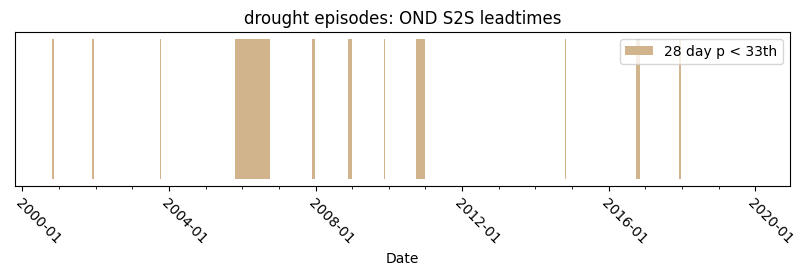

In [8]:
plot_bar_code(filter_by_season(tt,[10,11,12], "OND"), "OND S2S leadtimes")

/tmp/ipykernel_2391714/1866760617.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = -45, ha='left', rotation_mode='anchor')


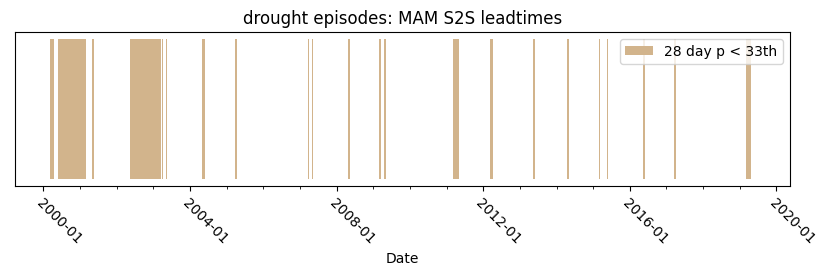

In [9]:
plot_bar_code(filter_by_season(tt,[3,4,5], "MAM"), "MAM S2S leadtimes")

/tmp/ipykernel_2391714/1866760617.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = -45, ha='left', rotation_mode='anchor')


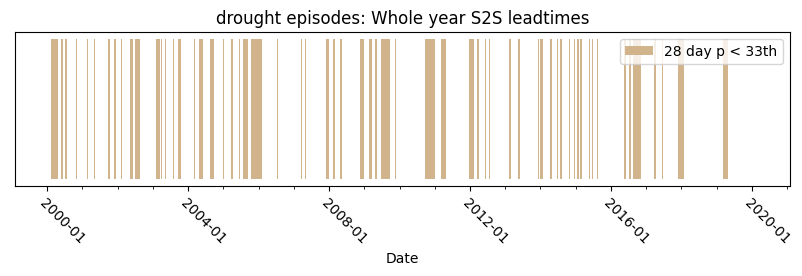

In [10]:
plot_bar_code(tt, "Whole year S2S leadtimes")

/tmp/ipykernel_2391714/1866760617.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = -45, ha='left', rotation_mode='anchor')


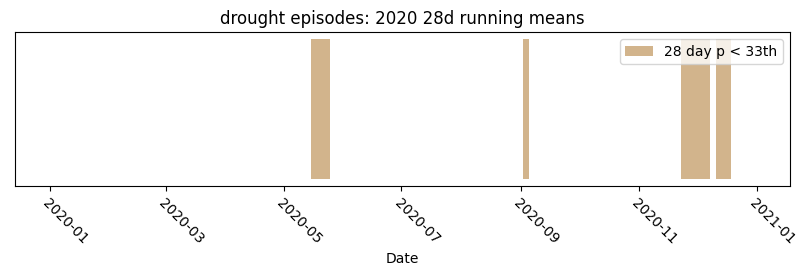

In [11]:
plot_bar_code(test.where(test.valid_time.dt.year==2020,drop=True), "2020 28d running means")

/tmp/ipykernel_2391714/1866760617.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = -45, ha='left', rotation_mode='anchor')


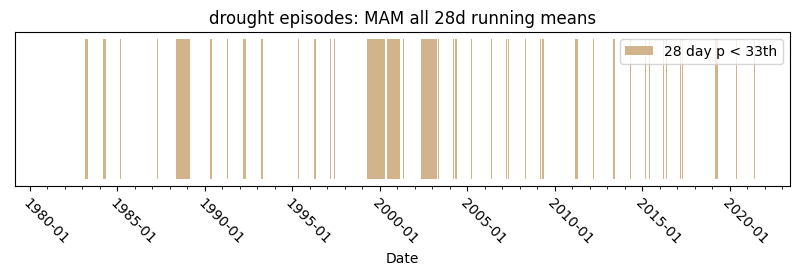

In [12]:
plot_bar_code(filter_by_season(test, [3,4,5], "MAM"), "MAM all 28d running means")

/tmp/ipykernel_2391714/1866760617.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = -45, ha='left', rotation_mode='anchor')


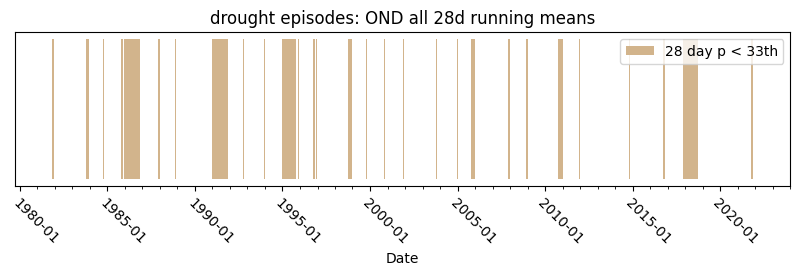

In [13]:
plot_bar_code(filter_by_season(test, [10,11,12], "OND"), "OND all 28d running means")